# Importing Dependencies

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, GRU, BatchNormalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import glob
import os

2026-02-24 14:23:31.730448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading Dataset

In [3]:
# original = pl.read_csv("Entire_Dataset/UNSW_2018_IoT_Botnet_Dataset_1.csv", n_rows=0)
# merged = pl.read_csv("Final_Merged_Dataset.csv", n_rows=0, ignore_errors=True)

# missing = set(original.columns) - set(merged.columns)
# print(missing)


In [4]:
cols = pl.read_csv('Bot_Iot_final_scaled.csv', n_rows=0, ignore_errors=True).columns

schema_overide = {c: pl.Float64 for c in cols if c!="attack"}
schema_overide["attack"] = pl.Int8

df = pl.scan_csv("Bot_Iot_final_scaled.csv", infer_schema_length=None)

In [5]:
print(cols)

['pkSeqID', 'stime', 'sport', 'dport', 'pkts', 'bytes', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'attack', 'flgs_eU', 'flgs_e_dS', 'flgs_e_&', 'flgs_e_r', 'flgs_e', 'flgs_e___t', 'flgs_e__D', 'flgs_e____F', 'flgs_e_d', 'flgs_e_g', 'flgs_e_*', 'flgs_e_s', 'flgs_e_dD', 'proto_igmp', 'proto_tcp', 'proto_ipv6-icmp', 'proto_arp', 'proto_rarp', 'proto_udp', 'proto_icmp', 'state_NRS', 'state_TST', 'state_INT', 'state_ECO', 'state_MAS', 'state_CON', 'state_ACC', 'state_CLO', 'state_REQ', 'state_URP', 'state_FIN', 'state_RST', 'state_PAR', 'state_RSP', 'saddr_1', 'saddr_2', 'saddr_3', 'saddr_4', 'daddr_1', 'daddr_2', 'daddr_3', 'daddr_4']


In [6]:
# pl.read_csv("Bot_Iot_final_scaled.csv", n_rows=0).columns

In [7]:
# target_counts = (
#     df.select(pl.col("attack").value_counts())
#     .collect()
# )
# print(target_counts)

In [8]:
# total_rows = df.select(pl.len()).collect().item()
# split_idx = int(total_rows * 0.8)

In [9]:
# train_df = df.slice(0, split_idx)
# test_df  = df.slice(split_idx, total_rows - split_idx)

In [10]:
LABEL_COL = 'attack'
BATCH_SIZE = 1024
WINDOW = 20
MODEL_BATCH = 64

FEATURE_COLS = [c for c in cols if c != LABEL_COL]
SELECTED_COLS = FEATURE_COLS + [LABEL_COL]
NUM_FEATURES = len(FEATURE_COLS)


def get_dataset(file_path):

    column_defaults = []

    for col in SELECTED_COLS:
        if col == LABEL_COL:
            column_defaults.append(tf.float32)
        else:
            column_defaults.append(tf.float32)

    return tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=BATCH_SIZE,
        label_name=LABEL_COL,
        select_columns=SELECTED_COLS,
        column_defaults=column_defaults,
        na_value ="?",
        num_epochs=1,
        shuffle=False
    )


def pack(features, label):
    x = tf.stack(
        [tf.cast(features[col], tf.float32) for col in FEATURE_COLS],
        axis=1
    )
    return x, tf.cast(label, tf.float32)


def build_pipeline(file_path):

    dataset = get_dataset(file_path)
    dataset = dataset.map(pack)

    dataset = dataset.unbatch()

    dataset = dataset.window(WINDOW, shift=WINDOW, drop_remainder=True)

    dataset = dataset.flat_map(
        lambda x, y: tf.data.Dataset.zip((
            x.batch(WINDOW),
            y.batch(WINDOW)
        ))
    )

    dataset = dataset.map(lambda x, y: (x, y[-1]))

    dataset = dataset.batch(MODEL_BATCH, drop_remainder=False)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


train_dataset = build_pipeline("train.csv")
test_dataset  = build_pipeline("test.csv")

I0000 00:00:1771923215.551755   32622 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2150 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
for x, y in train_dataset.take(1):
    print("X shape:", x.shape)
    print("Y shape:", y.shape)

X shape: (64, 20, 63)
Y shape: (64,)


2026-02-24 14:16:54.321038: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
print("Train cardinality:", tf.data.experimental.cardinality(train_dataset))
print("Test cardinality:", tf.data.experimental.cardinality(test_dataset))

Train cardinality: tf.Tensor(-2, shape=(), dtype=int64)
Test cardinality: tf.Tensor(-2, shape=(), dtype=int64)


# Model Training

In [59]:
train_dataset = build_pipeline('train.csv')
test_dataset = build_pipeline('test.csv')

In [60]:
for x, y in train_dataset.take(1):
    print("X shape:", x.shape)
    print("Y shape:", y.shape)

X shape: (64, 20, 63)
Y shape: (64,)


2026-02-24 13:37:55.418092: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
model1 = Sequential([
    tf.keras.layers.Input(shape=(WINDOW, NUM_FEATURES)),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

history = model1.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,
)

Epoch 1/5
  45857/Unknown 1352s 29ms/step - accuracy: 0.9998 - loss: 0.0015 - precision_2: 0.9998 - recall_2: 1.0000

2026-02-24 01:09:56.599115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12622754212499464404
2026-02-24 01:09:56.599134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1857248148602060777


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1352s 29ms/step - accuracy: 0.9999 - loss: 8.1177e-04 - precision_2: 0.9999 - recall_2: 1.0000
Epoch 2/5
45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1344s 29ms/step - accuracy: 0.9999 - loss: 8.4712e-04 - precision_2: 0.9999 - recall_2: 1.0000
Epoch 3/5
    1/45857 ━━━━━━━━━━━━━━━━━━━━ 1:20:50 106ms/step - accuracy: 1.0000 - loss: 2.2815e-05 - precision_2: 1.0000 - recall_2: 1.0000

2026-02-24 01:32:20.435438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1857248148602060777
2026-02-24 01:32:20.435457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12622754212499464404
2026-02-24 01:32:20.496636: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-02-24 01:32:20.496663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9306013647925014105
2026-02-24 01:32:20.496668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13076507973698146470
2026-02-24 01:32:20.496678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7468919794086682342


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1346s 29ms/step - accuracy: 0.9999 - loss: 7.4948e-04 - precision_2: 0.9999 - recall_2: 1.0000
Epoch 4/5
    1/45857 ━━━━━━━━━━━━━━━━━━━━ 1:22:31 108ms/step - accuracy: 1.0000 - loss: 1.5629e-04 - precision_2: 1.0000 - recall_2: 1.0000

2026-02-24 01:54:46.503424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1857248148602060777
2026-02-24 01:54:46.503444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12622754212499464404
2026-02-24 01:54:46.561650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9306013647925014105
2026-02-24 01:54:46.561673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13076507973698146470
2026-02-24 01:54:46.561682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7468919794086682342


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1343s 29ms/step - accuracy: 0.9999 - loss: 7.4035e-04 - precision_2: 0.9999 - recall_2: 1.0000
Epoch 5/5
    4/45857 ━━━━━━━━━━━━━━━━━━━━ 17:04 22ms/step - accuracy: 1.0000 - loss: 3.8400e-04 - precision_2: 1.0000 - recall_2: 1.0000   

2026-02-24 02:17:09.120385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9306013647925014105
2026-02-24 02:17:09.120405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13076507973698146470
2026-02-24 02:17:09.120416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7468919794086682342


45857/45857 ━━━━━━━━━━━━━━━━━━━━ 1182s 26ms/step - accuracy: 0.9999 - loss: 6.4799e-04 - precision_2: 0.9999 - recall_2: 1.0000


2026-02-24 02:36:51.492362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10212245870866322139
2026-02-24 02:36:51.492383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1857248148602060777
2026-02-24 02:36:51.492389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12622754212499464404
2026-02-24 02:36:51.543443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9306013647925014105
2026-02-24 02:36:51.543465: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13076507973698146470
2026-02-24 02:36:51.543477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7468919794086682342


In [37]:
model1.save('iot_model_cnnlstm.keras')

In [61]:
test_dataset_temp = build_pipeline("test.csv")

test_steps = 0
for _ in test_dataset_temp:
    test_steps += 1

print("Test steps:", test_steps)

Test steps: 0


In [3]:
df_lazy = pl.scan_csv("Bot_Iot_final_scaled.csv")

# Count rows safely
total_rows = df_lazy.select(pl.len()).collect().item()
print("Total rows:", total_rows)

split_index = int(0.8 * total_rows)

Total rows: 73370194


In [4]:
print(split_index)

58696155


In [5]:
(
    df_lazy
    .slice(split_index, total_rows - split_index)
    .collect(streaming=True)
    .write_csv("test.csv")
)

/tmp/ipykernel_27932/1775421406.py:4: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


In [6]:
print(pl.scan_csv("train.csv").select(pl.len()).collect())
print(pl.scan_csv("test.csv").select(pl.len()).collect())

shape: (1, 1)
┌──────────┐
│ len      │
│ ---      │
│ u32      │
╞══════════╡
│ 58696155 │
└──────────┘
shape: (1, 1)
┌──────────┐
│ len      │
│ ---      │
│ u32      │
╞══════════╡
│ 14674039 │
└──────────┘


In [ ]:
df = pl.read_csv("test.csv")

X = df.select(FEATURE_COLS).to_numpy()
y = df[LABEL_COL].to_numpy()

In [11]:
model = tf.keras.models.load_model('iot_model_cnnlstm.keras')

In [14]:
import polars as pl
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

WINDOW = 20
BATCH_SIZE = 100000  # rows per chunk

y_true_all = []
y_pred_all = []
y_prob_all = []

offset = 0

while True:
    chunk = (
        pl.scan_csv("test.csv")
        .slice(offset, BATCH_SIZE)
        .collect(streaming=True)
    )
    
    if chunk.height == 0:
        break
    
    X = chunk.select(FEATURE_COLS).to_numpy().astype(np.float32)
    y = chunk[LABEL_COL].to_numpy().astype(np.float32)
    
    num_windows = len(X) // WINDOW
    if num_windows == 0:
        break
    
    X = X[:num_windows * WINDOW]
    y = y[:num_windows * WINDOW]
    
    X_seq = X.reshape(num_windows, WINDOW, -1)
    y_seq = y.reshape(num_windows, WINDOW)
    y_final = y_seq[:, -1]
    
    y_pred_prob = model.predict(X_seq, batch_size=64, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    y_true_all.extend(y_final)
    y_pred_all.extend(y_pred)
    y_prob_all.extend(y_pred_prob.flatten())
    
    offset += BATCH_SIZE

print(classification_report(y_true_all, y_pred_all))

/tmp/ipykernel_32622/1096809477.py:18: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


              precision    recall  f1-score   support

         0.0       0.00      0.63      0.00        19
         1.0       1.00      0.94      0.97    733682

    accuracy                           0.94    733701
   macro avg       0.50      0.78      0.48    733701
weighted avg       1.00      0.94      0.97    733701



In [18]:
y_true = np.array(y_true_all)
y_prob = np.array(y_prob_all)

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)

print("NaNs in y_true:", np.isnan(y_true).sum())
print("NaNs in y_prob:", np.isnan(y_prob).sum())

print("Inf in y_prob:", np.isinf(y_prob).sum())

y_true shape: (733701,)
y_prob shape: (733701,)
NaNs in y_true: 0
NaNs in y_prob: 107
Inf in y_prob: 0


In [20]:
y_true = np.array(y_true_all)
y_prob = np.array(y_prob_all)

mask = ~np.isnan(y_prob)

y_true_clean = y_true[mask]
y_prob_clean = y_prob[mask]

print("Removed NaN samples:", len(y_true) - len(y_true_clean))

auc_score = roc_auc_score(y_true_clean, y_prob_clean)
print("ROC-AUC Score:", auc_score)

Removed NaN samples: 107
ROC-AUC Score: 0.8568952695612869


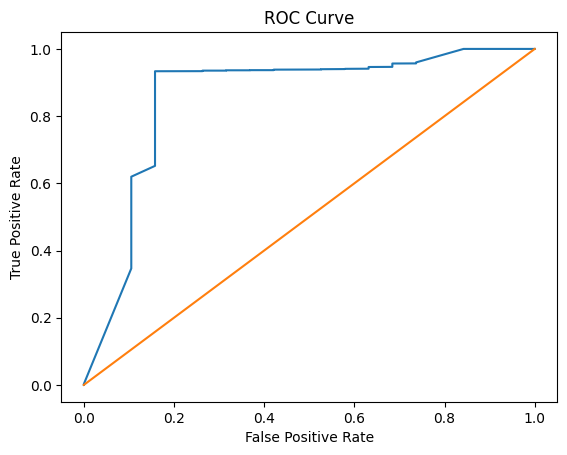

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_true_clean, y_prob_clean)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

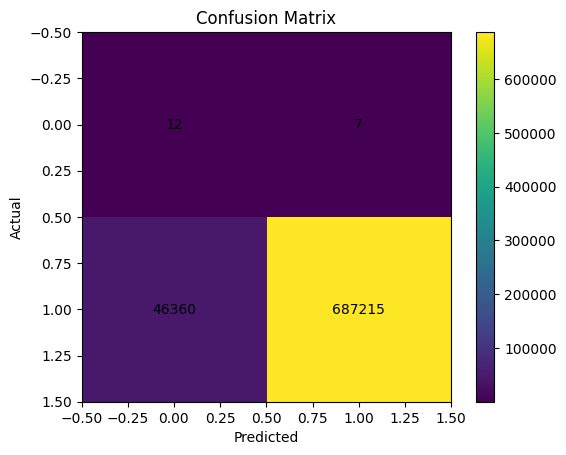

In [23]:
cm = confusion_matrix(y_true_clean, (y_prob_clean > 0.5))

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()

In [16]:
train_dataset = build_pipeline("train.csv")
test_dataset  = build_pipeline("test.csv")

In [40]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2'])


In [ ]:
model2 = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(WINDOW,NUM_FEATURES)),
        MaxPooling1D(2),
        GRU(64),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

for x, y in train_dataset.take(1):
    print("X:", x.shape)
    print("Y:", y.shape)

history = model2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2
)

/home/sathya/Major/IoT_venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


X: (64, 20, 63)
Y: (64,)
Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 122s 24ms/step - accuracy: 0.9993 - loss: 0.0038 - precision_1: 0.9995 - recall_1: 0.9998
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 125s 25ms/step - accuracy: 0.9999 - loss: 3.8686e-04 - precision_1: 1.0000 - recall_1: 1.0000
Epoch 3/5
  10/5000 ━━━━━━━━━━━━━━━━━━━━ 1:42 21ms/step - accuracy: 1.0000 - loss: 2.3143e-05 - precision_1: 1.0000 - recall_1: 1.0000

2026-02-24 00:14:52.821523: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-02-24 00:14:52.821551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15116841708026373479
2026-02-24 00:14:52.821562: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8046240090238013063
2026-02-24 00:14:52.821583: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4607529968174767998


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 125s 25ms/step - accuracy: 1.0000 - loss: 1.7762e-04 - precision_1: 1.0000 - recall_1: 1.0000
Epoch 4/5
   6/5000 ━━━━━━━━━━━━━━━━━━━━ 1:54 23ms/step - accuracy: 1.0000 - loss: 1.3580e-05 - precision_1: 1.0000 - recall_1: 1.0000

2026-02-24 00:16:57.935609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15116841708026373479
2026-02-24 00:16:57.935635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8046240090238013063
2026-02-24 00:16:57.935653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4607529968174767998


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 124s 25ms/step - accuracy: 1.0000 - loss: 1.2798e-04 - precision_1: 1.0000 - recall_1: 1.0000
Epoch 5/5
   8/5000 ━━━━━━━━━━━━━━━━━━━━ 1:46 21ms/step - accuracy: 1.0000 - loss: 8.6006e-07 - precision_1: 1.0000 - recall_1: 1.0000

2026-02-24 00:19:02.427240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15116841708026373479
2026-02-24 00:19:02.427262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8046240090238013063
2026-02-24 00:19:02.427279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4607529968174767998


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 124s 25ms/step - accuracy: 1.0000 - loss: 2.8875e-04 - precision_1: 1.0000 - recall_1: 1.0000


2026-02-24 00:21:06.243721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15116841708026373479
2026-02-24 00:21:06.243746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8046240090238013063
2026-02-24 00:21:06.243764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4607529968174767998


In [ ]:
model2.save('iot_model_cnngru.keras')

In [25]:
model2 = tf.keras.models.load_model('iot_model_cnngru.keras')

WINDOW = 20
BATCH_SIZE = 100000  # rows per chunk

y_true_all = []
y_pred_all = []
y_prob_all = []

offset = 0

while True:
    chunk = (
        pl.scan_csv("test.csv")
        .slice(offset, BATCH_SIZE)
        .collect(streaming=True)
    )
    
    if chunk.height == 0:
        break
    
    X = chunk.select(FEATURE_COLS).to_numpy().astype(np.float32)
    y = chunk[LABEL_COL].to_numpy().astype(np.float32)
    
    num_windows = len(X) // WINDOW
    if num_windows == 0:
        break
    
    X = X[:num_windows * WINDOW]
    y = y[:num_windows * WINDOW]
    
    X_seq = X.reshape(num_windows, WINDOW, -1)
    y_seq = y.reshape(num_windows, WINDOW)
    y_final = y_seq[:, -1]
    
    y_pred_prob = model2.predict(X_seq, batch_size=64, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    y_true_all.extend(y_final)
    y_pred_all.extend(y_pred)
    y_prob_all.extend(y_pred_prob.flatten())
    
    offset += BATCH_SIZE

print(classification_report(y_true_all, y_pred_all))

/tmp/ipykernel_32622/1529727623.py:16: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


              precision    recall  f1-score   support

         0.0       0.00      0.74      0.00        19
         1.0       1.00      0.91      0.95    733682

    accuracy                           0.91    733701
   macro avg       0.50      0.82      0.48    733701
weighted avg       1.00      0.91      0.95    733701



In [26]:
y_true = np.array(y_true_all)
y_prob = np.array(y_prob_all)

print("y_true shape:", y_true.shape)
print("y_prob shape:", y_prob.shape)

print("NaNs in y_true:", np.isnan(y_true).sum())
print("NaNs in y_prob:", np.isnan(y_prob).sum())

print("Inf in y_prob:", np.isinf(y_prob).sum())

y_true shape: (733701,)
y_prob shape: (733701,)
NaNs in y_true: 0
NaNs in y_prob: 65919
Inf in y_prob: 0


In [27]:
y_true = np.array(y_true_all)
y_prob = np.array(y_prob_all)

mask = ~np.isnan(y_prob)

y_true_clean = y_true[mask]
y_prob_clean = y_prob[mask]

print("Removed NaN samples:", len(y_true) - len(y_true_clean))

auc_score = roc_auc_score(y_true_clean, y_prob_clean)
print("ROC-AUC Score:", auc_score)

Removed NaN samples: 65919
ROC-AUC Score: 0.48918037009360904


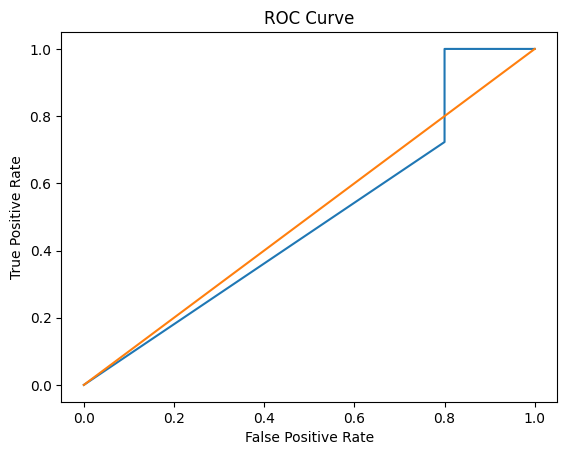

In [28]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_true_clean, y_prob_clean)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

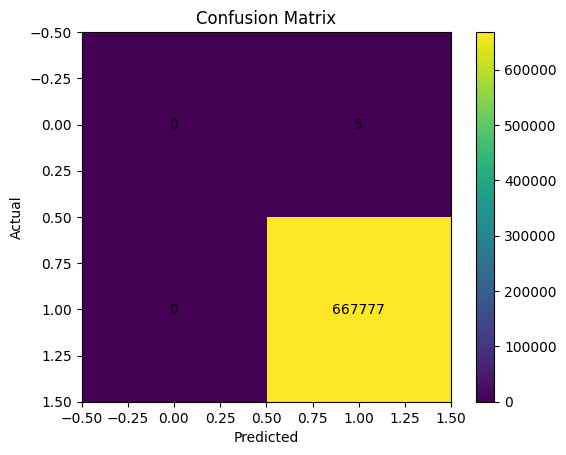

In [29]:
cm = confusion_matrix(y_true_clean, (y_prob_clean > 0.5))

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()